In [2]:
import os
import sys
import itertools

import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
import keras
from keras import optimizers
from keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import os

# Define dataset paths
ROOT_DIR = "chest_xray/chest_xray"
train_dir = os.path.join(ROOT_DIR, "train")
test_dir = os.path.join(ROOT_DIR, "test")
val_dir = os.path.join(ROOT_DIR, "val")

# Verify that the paths exist
if not os.path.isdir(train_dir):
    raise FileNotFoundError(f"Training directory not found: {train_dir}")
if not os.path.isdir(val_dir):
    raise FileNotFoundError(f"Validation directory not found: {val_dir}")

print(f"Training data directory: {train_dir}")

print(f"Test data directory: {test_dir}")
print(f"Validation data directory: {val_dir}")


Training data directory: chest_xray/chest_xray\train
Test data directory: chest_xray/chest_xray\test
Validation data directory: chest_xray/chest_xray\val


In [24]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image

# Define image size and dataset paths
IMAGE_SIZE = (64, 64)

# Define dataset paths
ROOT_DIR = "chest_xray/chest_xray"
train_dir = os.path.join(ROOT_DIR, "train")
test_dir = os.path.join(ROOT_DIR, "test")
val_dir = os.path.join(ROOT_DIR, "val")

# Dictionary for encoding the dataset labels
classID = {'NORMAL': 0, 'PNEUMONIA': 1}

dataset = []

# Iterate over the train and validation sets
for fold_dir, fold_name in zip([train_dir,test_dir, val_dir], ['train','test' 'val']):
    print(f"\nProcessing fold: {fold_name}")

    # Iterate over classes in a set
    for class_dir in glob(os.path.join(fold_dir, '*')):
        label = os.path.basename(class_dir).upper()
        print(f"Processing class: {label}")

        # Iterate over images in a class
        for filename in tqdm(os.listdir(class_dir), file=sys.stdout):
            if filename.endswith(".jpeg"):
                # Get additional info about the type of pneumonia
                if label == 'PNEUMONIA':
                    info = filename.split("_")[1] if "_" in filename else 'unknown'
                else:
                    info = 'n.a.d.'  # No abnormalities detected

                img_file_path = os.path.join(class_dir, filename)

                # Resize and convert the image to a predefined shape and RGB color space
                image = np.array(Image.open(img_file_path).resize(IMAGE_SIZE).convert('RGB'))

                dataset.append([image, info, label, classID[label], fold_name])

# Convert to a Pandas DataFrame
cxr_df = pd.DataFrame(dataset, columns=['image', 'info', 'label', 'classID', 'fold'])  # Chest X-ray DataFrame
cxr_df = cxr_df.astype({'info': 'category', 'label': 'category', 'classID': 'uint8', 'fold': 'category'})

print(f"Dataset prepared with {len(cxr_df)} entries.")



Processing fold: train
Processing class: NORMAL
  0%|          | 0/1341 [00:00<?, ?it/s]

100%|██████████| 1341/1341 [00:15<00:00, 83.96it/s] 
Processing class: PNEUMONIA
100%|██████████| 3875/3875 [00:15<00:00, 249.38it/s]

Processing fold: testval
Processing class: NORMAL
100%|██████████| 234/234 [00:01<00:00, 120.66it/s]
Processing class: PNEUMONIA
100%|██████████| 390/390 [00:01<00:00, 287.24it/s]
Dataset prepared with 5840 entries.


In [25]:
STORE_DATA = False

if STORE_DATA:
    cxr_df.to_pickle('cxr_df.pkl')

In [26]:
LOAD_DATA = True
SAVE_DATA = True

DATAFRAME_PATH = 'cxr_df.pkl'

if LOAD_DATA and os.path.exists(DATAFRAME_PATH):
    # Load the DataFrame if the file exists
    cxr_df = pd.read_pickle(DATAFRAME_PATH)
    print(f"DataFrame loaded successfully with {len(cxr_df)} entries.")
else:
    # Generate the DataFrame
    dataset = []

    # Same dataset creation code as before
    for fold_dir, fold_name in zip([train_dir,test_dir, val_dir], ['train','test' ,'val']):
        print(f"\nProcessing fold: {fold_name}")
        for class_dir in glob(os.path.join(fold_dir, '*')):
            label = os.path.basename(class_dir).upper()
            print(f"Processing class: {label}")
            for filename in tqdm(os.listdir(class_dir), file=sys.stdout):
                if filename.endswith(".jpeg"):
                    info = filename.split("_")[1] if label == 'PNEUMONIA' else 'n.a.d.'
                    img_file_path = os.path.join(class_dir, filename)
                    image = np.array(Image.open(img_file_path).resize(IMAGE_SIZE).convert('RGB'))
                    dataset.append([image, info, label, classID[label], fold_name])

    # Convert to DataFrame
    cxr_df = pd.DataFrame(dataset, columns=['image', 'info', 'label', 'classID', 'fold'])
    cxr_df = cxr_df.astype({'info': 'category', 'label': 'category', 'classID': 'uint8', 'fold': 'category'})
    print(f"DataFrame created with {len(cxr_df)} entries.")

    # Save the DataFrame if enabled
    if SAVE_DATA:
        cxr_df.to_pickle(DATAFRAME_PATH)
        print(f"DataFrame saved to {DATAFRAME_PATH}.")



Processing fold: train
Processing class: NORMAL
100%|██████████| 1341/1341 [00:15<00:00, 86.60it/s] 
Processing class: PNEUMONIA
100%|██████████| 3875/3875 [00:14<00:00, 263.68it/s]

Processing fold: test
Processing class: NORMAL
100%|██████████| 234/234 [00:01<00:00, 124.88it/s]
Processing class: PNEUMONIA
100%|██████████| 390/390 [00:01<00:00, 307.37it/s]

Processing fold: val
Processing class: NORMAL
100%|██████████| 8/8 [00:00<00:00, 133.59it/s]
Processing class: PNEUMONIA
100%|██████████| 8/8 [00:00<00:00, 273.10it/s]
DataFrame created with 5856 entries.
DataFrame saved to cxr_df.pkl.


In [27]:
cxr_df

,image,info,label,classID,fold
0,"[[[19, 19, 19], [27, 27, 27], [62, 62, 62], [7...",n.a.d.,NORMAL,0,train
1,"[[[24, 24, 24], [36, 36, 36], [44, 44, 44], [5...",n.a.d.,NORMAL,0,train
2,"[[[0, 0, 0], [19, 19, 19], [40, 40, 40], [59, ...",n.a.d.,NORMAL,0,train
3,"[[[44, 44, 44], [56, 56, 56], [71, 71, 71], [8...",n.a.d.,NORMAL,0,train
4,"[[[80, 80, 80], [65, 65, 65], [44, 44, 44], [3...",n.a.d.,NORMAL,0,train
...,...,...,...,...,...
5851,"[[[1, 1, 1], [19, 19, 19], [31, 31, 31], [62, ...",bacteria,PNEUMONIA,1,val
5852,"[[[0, 0, 0], [13, 13, 13], [44, 44, 44], [81, ...",bacteria,PNEUMONIA,1,val
5853,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [66, 66, 66...",bacteria,PNEUMONIA,1,val
5854,"[[[59, 59, 59], [58, 58, 58], [74, 74, 74], [1...",bacteria,PNEUMONIA,1,val


In [28]:
cxr_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   image    5856 non-null   object  
 1   info     5856 non-null   category
 2   label    5856 non-null   category
 3   classID  5856 non-null   uint8   
 4   fold     5856 non-null   category
dtypes: category(3), object(1), uint8(1)
memory usage: 69.5 MB


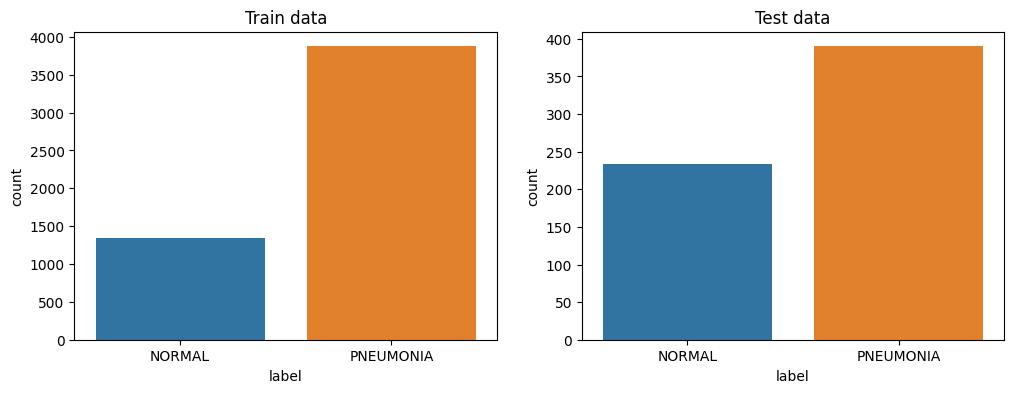

In [29]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x = cxr_df[cxr_df['fold'] == 'train']['label'])
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(x = cxr_df[cxr_df['fold'] == 'test']['label'])
plt.title('Test data')

plt.savefig('class_distribution_sns.png')

plt.show()

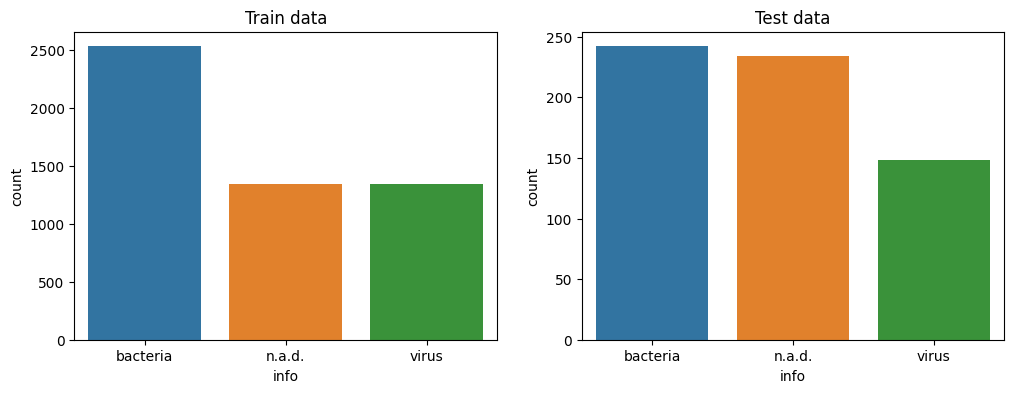

In [30]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x = cxr_df[(cxr_df.fold == 'train')]['info'])
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(x = cxr_df[(cxr_df.fold == 'test')]['info'])
plt.title('Test data')

plt.savefig('type_distribution_.png')

plt.show()

In [31]:
def show_batch(batch, size, hspace=0.28, wspace=0.2, title=None):
    """Show the images from the `batch`."""
    height, width = size

    plt.figure(figsize=(10,10))
    
    if title is not None:
        plt.suptitle(title, weight='bold', y=0.96)

    for n in range(height*width):
        ax = plt.subplot(height, width, n+1)
        
        plt.imshow(batch[n][0])
        plt.title(batch[n][1])
        plt.subplots_adjust(wspace=wspace, hspace=hspace)
        plt.axis("off")

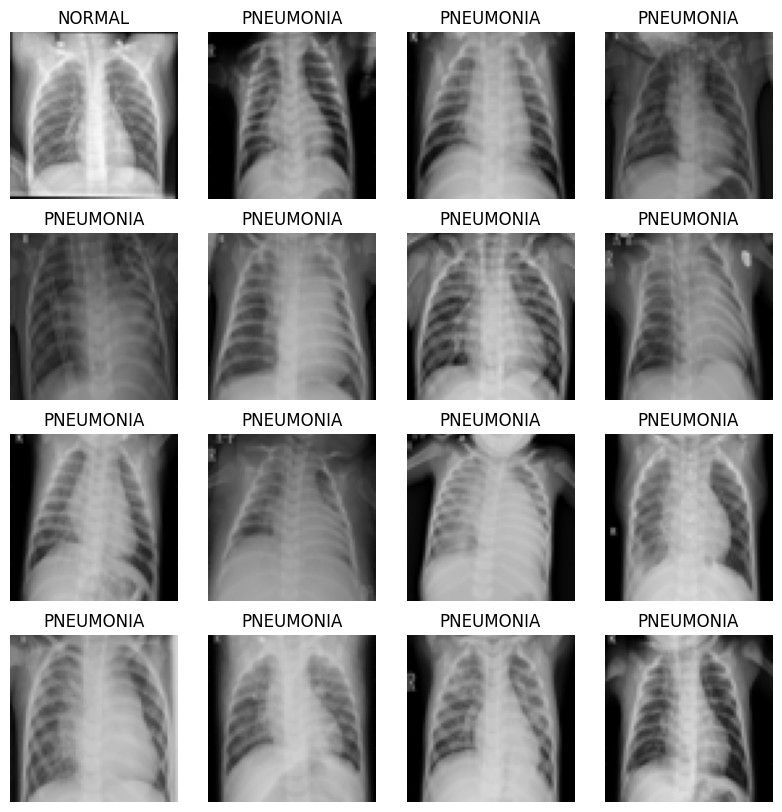

In [32]:
# random batch from the dataset
sample_batch = cxr_df[['image', 'label']].sample(frac=1).to_numpy()

show_batch(sample_batch, size=(4, 4), hspace=0.2, wspace=0.1)
plt.savefig('sample_batch.png')

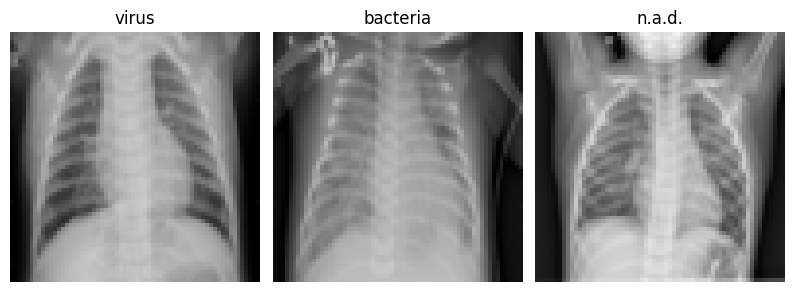

In [33]:
# Correct filtering using case-sensitive values
pneumonia_virus_xray = cxr_df[(cxr_df['label'] == 'PNEUMONIA') & (cxr_df['info'] == 'virus')].head(1)
pneumonia_bacteria_xray = cxr_df[(cxr_df['label'] == 'PNEUMONIA') & (cxr_df['info'] == 'bacteria')].head(1)
normal_xray = cxr_df[(cxr_df['label'] == 'NORMAL')].head(1)

# Ensure non-empty selections
if not pneumonia_virus_xray.empty:
    pneumonia_virus_xray = pneumonia_virus_xray.iloc[0][['image', 'info']]
else:
    print("No virus pneumonia images found!")
    pneumonia_virus_xray = None

if not pneumonia_bacteria_xray.empty:
    pneumonia_bacteria_xray = pneumonia_bacteria_xray.iloc[0][['image', 'info']]
else:
    print("No bacterial pneumonia images found!")
    pneumonia_bacteria_xray = None

if not normal_xray.empty:
    normal_xray = normal_xray.iloc[0][['image', 'info']]
else:
    print("No normal images found!")
    normal_xray = None

# Check if all samples are valid before visualization
sample_batch = [x for x in [pneumonia_virus_xray, pneumonia_bacteria_xray, normal_xray] if x is not None]

if sample_batch:
    show_batch(sample_batch, size=(1, len(sample_batch)), wspace=0.05)
    plt.savefig('different_types.png')
else:
    print("No images available for visualization!")


In [34]:
print(cxr_df['label'].unique())  # Check unique values in the 'label' column
print(cxr_df['info'].unique())   # Check unique values in the 'info' column


['NORMAL', 'PNEUMONIA']
Categories (2, object): ['NORMAL', 'PNEUMONIA']
['n.a.d.', 'bacteria', 'virus']
Categories (3, object): ['bacteria', 'n.a.d.', 'virus']


In [35]:
# input image size
IMAGE_SIZE = (64, 64, 3)

# instantiate a base model with pre-trained weights
vgg19 = VGG19(weights='imagenet',         # load weights pre-trained on ImageNet
              include_top=False,          # do not include the ImageNet classifier at the top
              input_shape=IMAGE_SIZE)  

# freeze the base model
vgg19.trainable = False

# create a new model on top
inputs = keras.Input(shape=IMAGE_SIZE)
x = vgg19(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [36]:
vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 2, 2, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,897 (76.39 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [38]:
# split the data into train and test sets (predefined)
train_cxr_df = cxr_df[cxr_df['fold']=='train'][['image', 'classID']]
test_cxr_df = cxr_df[cxr_df['fold']=='test'][['image', 'classID']]

# split the train data into train and validation sets
train_cxr_df, val_cxr_df = train_test_split(train_cxr_df, test_size=0.2, shuffle=True)

# split the sets into examples and labels
X_train = np.stack(train_cxr_df['image'].to_numpy())
y_train = train_cxr_df['classID'].to_numpy()

X_val = np.stack(val_cxr_df['image'].to_numpy())
y_val = val_cxr_df['classID'].to_numpy()

X_test = np.stack(test_cxr_df['image'].to_numpy())
y_test = test_cxr_df['classID'].to_numpy()

In [39]:
pos, neg = train_cxr_df.classID.value_counts().to_numpy()

weight_for_0 = (1 / neg)*(pos+neg)/2.0 
weight_for_1 = (1 / pos)*(pos+neg)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


In [40]:
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = datagen.flow(X_train, 
                        y=y_train, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True)

val_it = datagen.flow(X_val, 
                      y=y_val, 
                      batch_size=BATCH_SIZE, 
                      shuffle=False)

test_it = datagen.flow(X_test, 
                       y=y_test, 
                       batch_size=BATCH_SIZE, 
                       shuffle=False)

In [41]:
EPOCHS = 25

# configure the model for training (Adam, Binary Cross-Entropy, Accuracy)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

# train only the trainable layers
history1 = model.fit(train_it, epochs=EPOCHS, validation_data=val_it, class_weight=class_weight)

Epoch 1/25


C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 64s 478ms/step - binary_accuracy: 0.3693 - loss: 0.6660 - val_binary_accuracy: 0.7730 - val_loss: 0.6229
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 532ms/step - binary_accuracy: 0.7964 - loss: 0.6220 - val_binary_accuracy: 0.8247 - val_loss: 0.5756
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 539ms/step - binary_accuracy: 0.8352 - loss: 0.5806 - val_binary_accuracy: 0.8295 - val_loss: 0.5502
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 540ms/step - binary_accuracy: 0.8362 - loss: 0.5626 - val_binary_accuracy: 0.8391 - val_loss: 0.5218
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 536ms/step - binary_accuracy: 0.8514 - loss: 0.5304 - val_binary_accuracy: 0.8448 - val_loss: 0.4988
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 71s 540ms/step - binary_accuracy: 0.8456 - loss: 0.5062 - val_binary_accuracy: 0.8429 - val_loss: 0.4865
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 73s 559ms/step - binary_accuracy: 0.8413 - loss: 0.5014 - val_binary_accuracy: 0.8487 - val_loss: 0.4

In [42]:
model.evaluate(test_it, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - binary_accuracy: 0.8175 - loss: 0.4580


{'binary_accuracy': 0.8381410241127014, 'loss': 0.39452216029167175}

In [43]:
EPOCHS_FT = 1

# unfreeze the base model
vgg19.trainable = True

# recompile the model with a smaller learning rate value
model.compile(optimizer=keras.optimizers.Adam(1e-5),  
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

# train end-to-end
history2 = model.fit(train_it, epochs=EPOCHS_FT, batch_size=BATCH_SIZE, validation_data=val_it, class_weight=class_weight)

131/131 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - binary_accuracy: 0.9215 - loss: 0.1737 - val_binary_accuracy: 0.9713 - val_loss: 0.0724


In [44]:
model.evaluate(test_it, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 399ms/step - binary_accuracy: 0.7022 - loss: 1.1139


{'binary_accuracy': 0.8253205418586731, 'loss': 0.6831245422363281}

In [46]:
def show_history(history, figsize=(15,5), save_fig=True, print_results=True):
    """Shows accuracy and loss graphs for train and validation sets."""    
    
    df = pd.DataFrame(history)

    sns.set()
    plt.figure(figsize=figsize)

    # accuracy graph
    plt.subplot(1,2,1)
    g = sns.lineplot(data=df[['binary_accuracy', 'val_binary_accuracy']], dashes=False)
    g.set(title='Model Accuracy', xlabel='Epoch', ylabel='Accuracy')
    g.legend(labels=['train', 'validation'])

    # loss graph
    plt.subplot(1,2,2)
    g = sns.lineplot(data=df[['loss', 'val_loss']], dashes=False)
    g.set(title='Model loss', xlabel='Epoch', ylabel='Loss')
    g.legend(labels=['train', 'validation'])

    plt.subplots_adjust(wspace=0.23)
    
    if save_fig:
        plt.savefig('acc_loss_graphs.png')

    plt.show()

    if print_results:
        print('\n\tMax train accuracy: %.4f %%\033[0m\t\t\t\tMin train loss: %.5f' % (df.binary_accuracy.max() * 100,
                                                                                      df.loss.min()))
        print('\tMax validation accuracy: %.4f %%\t\t\tMin validation loss: %.5f' % (df.val_binary_accuracy.max() * 100, 
                                                                                     df.val_loss.min()))

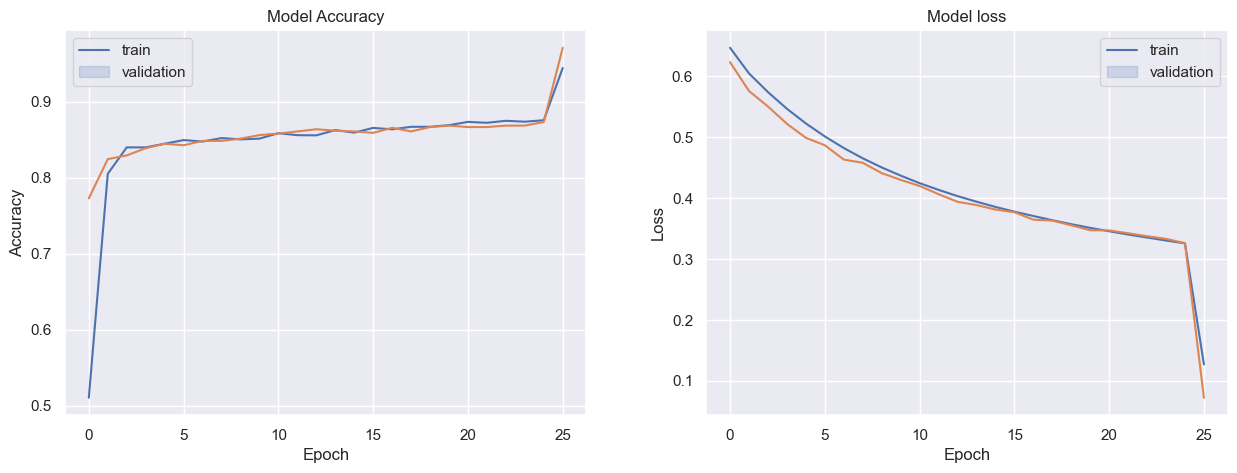


	Max train accuracy: 94.4631 %				Min train loss: 0.12714
	Max validation accuracy: 97.1264 %			Min validation loss: 0.07238


In [47]:
history1.history['binary_accuracy'] += history2.history['binary_accuracy']
history1.history['val_binary_accuracy'] += history2.history['val_binary_accuracy']
history1.history['loss'] += history2.history['loss']
history1.history['val_loss'] += history2.history['val_loss']

show_history(history1.history)

In [48]:
labels =  ['normal', 'pneumonia']

y_true = y_test
y_pred = tf.round(model.predict(x=test_it, batch_size=BATCH_SIZE)).numpy().T[0]

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step


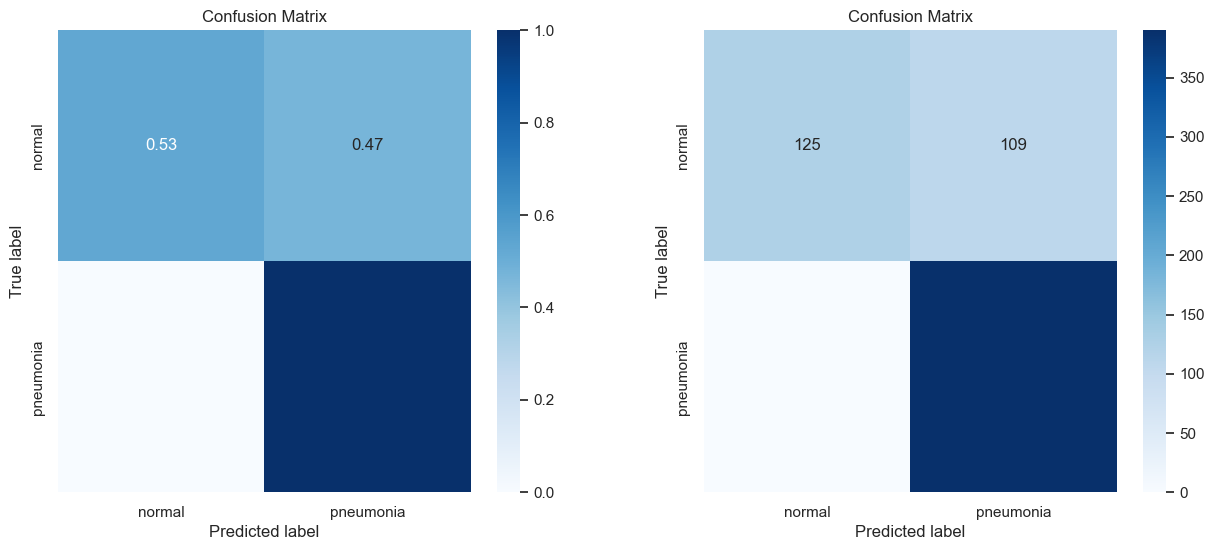

In [49]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred) 
cm_normalized = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true') 

# plot matrices and save the fig
plt.figure(figsize=(15,6))

for i, cmx in enumerate([cm_normalized, cm]):
    plt.subplot(1,2,i+1)
    cmx_df = pd.DataFrame(cmx, columns=labels, index=labels).round(2)
    g = sns.heatmap(cmx_df, annot=True, fmt='g', cmap='Blues')
    g.set(title='Confusion Matrix', xlabel='Predicted label', ylabel='True label')

plt.subplots_adjust(wspace=0.25)
plt.savefig('confusion_matrices.png')
plt.show()

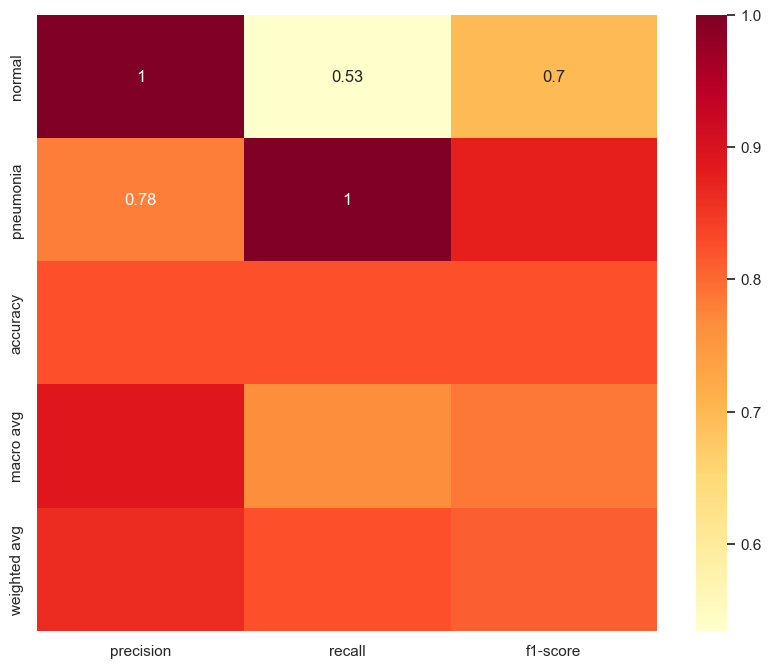

In [50]:
report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'], output_dict=True)
report = pd.DataFrame(report).iloc[:-1, :].T

# plot the classificaton report
plt.figure(figsize=(10,8))
sns.heatmap(report, annot=True, cmap='YlOrRd')
plt.yticks(va='center')
plt.savefig('classifcation_report.png')
plt.show()

In [51]:
def plot_top_losses(top_k, X, y_true, predict, loss, labels, **kwargs):
    """Shows the examples with the highest loss in the dataset."""
    
    y_pred = predict(x=X, batch_size=BATCH_SIZE)
    loss_values = np.array(loss(y_true, y_pred))
    top_k_idxs = loss_values.argsort()[-top_k:][::-1]

    worst_batch = []
    for idx in top_k_idxs:
        true_prob = y_test[idx]*y_pred[idx] + (1-y_test[idx])*(1-y_pred[idx])
        classID = int(y_true[idx])
        title = '%s / %.3f / %.4f' % (labels[classID], loss_values[idx], true_prob)
        worst_batch.append((X[idx], title))

    show_batch(worst_batch, title='Actual/Loss/Prediction_Probability', **kwargs)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step


C:\Users\Asus\AppData\Local\Temp\ipykernel_18228\422491696.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  classID = int(y_true[idx])
C:\Users\Asus\AppData\Local\Temp\ipykernel_18228\422491696.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title = '%s / %.3f / %.4f' % (labels[classID], loss_values[idx], true_prob)


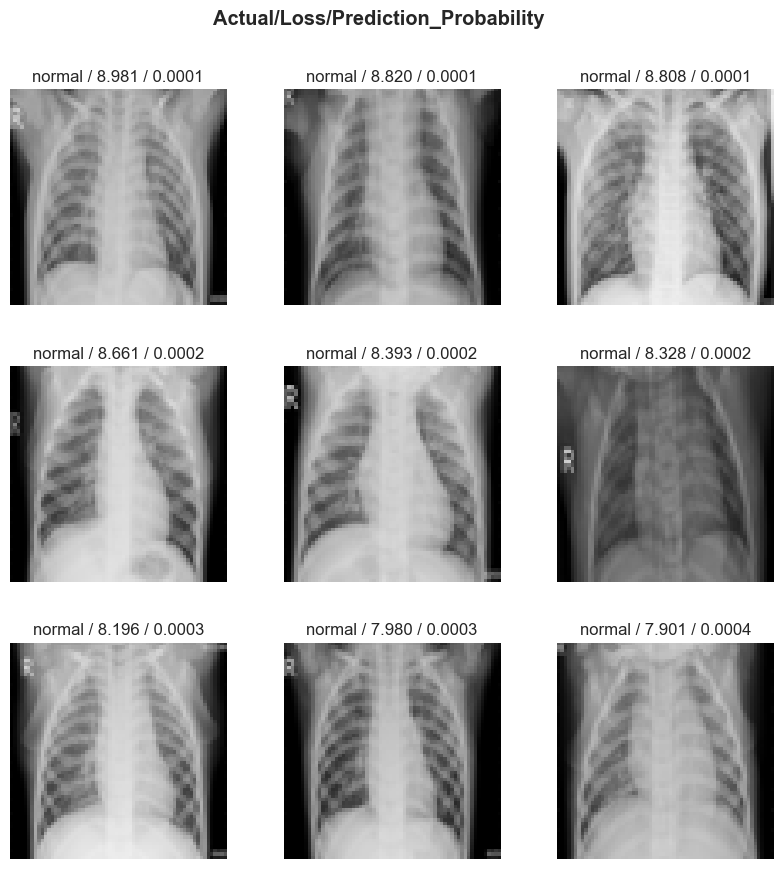

In [52]:
loss_f = keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

plot_top_losses(top_k=9,
                X=X_test/255.0, 
                y_true=y_test.reshape(-1, 1),               
                predict=model.predict, 
                loss=loss_f, 
                labels=labels,
                size=(3,3))

plt.savefig('top_losses.png', dpi=350)

In [53]:
# Save the model to an .h5 file
model_save_path = 'pneumonia_detection_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to pneumonia_detection_model.h5


In [56]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the model
model_path = 'pneumonia_detection_model.h5'
model = load_model(model_path)
print("Model loaded successfully!")


Model loaded successfully!


In [57]:
# Path to a sample image
image_path = 'person16_virus_47.jpeg'  # Replace with your test image path

# Load and preprocess the image
image_size = (64, 64)  # Ensure this matches your model's input size
image = load_img(image_path, target_size=image_size)  # Load and resize the image
image_array = img_to_array(image) / 255.0            # Convert to array and normalize
image_array = np.expand_dims(image_array, axis=0)    # Add batch dimension

print(f"Prepared image shape: {image_array.shape}")


Prepared image shape: (1, 64, 64, 3)


In [69]:
# Path to a sample image
image_path = 'person16_virus_47.jpeg'  # Replace with your test image path

# Load and preprocess the image
image_size = (64, 64)  # Ensure this matches your model's input size
image = load_img(image_path, target_size=image_size)  # Load and resize the image
image_array = img_to_array(image) / 255.0            # Convert to array and normalize
image_array = np.expand_dims(image_array, axis=0)    # Add batch dimension

print(f"Prepared image shape: {image_array.shape}")


Prepared image shape: (1, 64, 64, 3)


In [70]:
# Make a prediction
# Make a prediction
predicted_prob = model.predict(image_array)[0][0]  # Model prediction
predicted_class = 'Pneumonia' if predicted_prob >= 0.4 else 'Normal'

print(f"Predicted Probability: {predicted_prob:.2f}")
print(f"Predicted Class: {predicted_class}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted Probability: 0.47
Predicted Class: Pneumonia
